/tmp/ipython-input-7-2599974331.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-7-2599974331.py:66: RuntimeWarning: overflow encountered in scalar multiply
  mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
/tmp/ipython-input-7-2599974331.py:68: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-7-2599974331.py:40: RuntimeWarning: overflow encountered in divide
  positions = np.tanh(signal / threshold)
/tmp/ipython-input-7-2599974331.py:67: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
/tmp/ipython-input-7-2599974331.py:68: RuntimeWarning: invalid value encountered in 

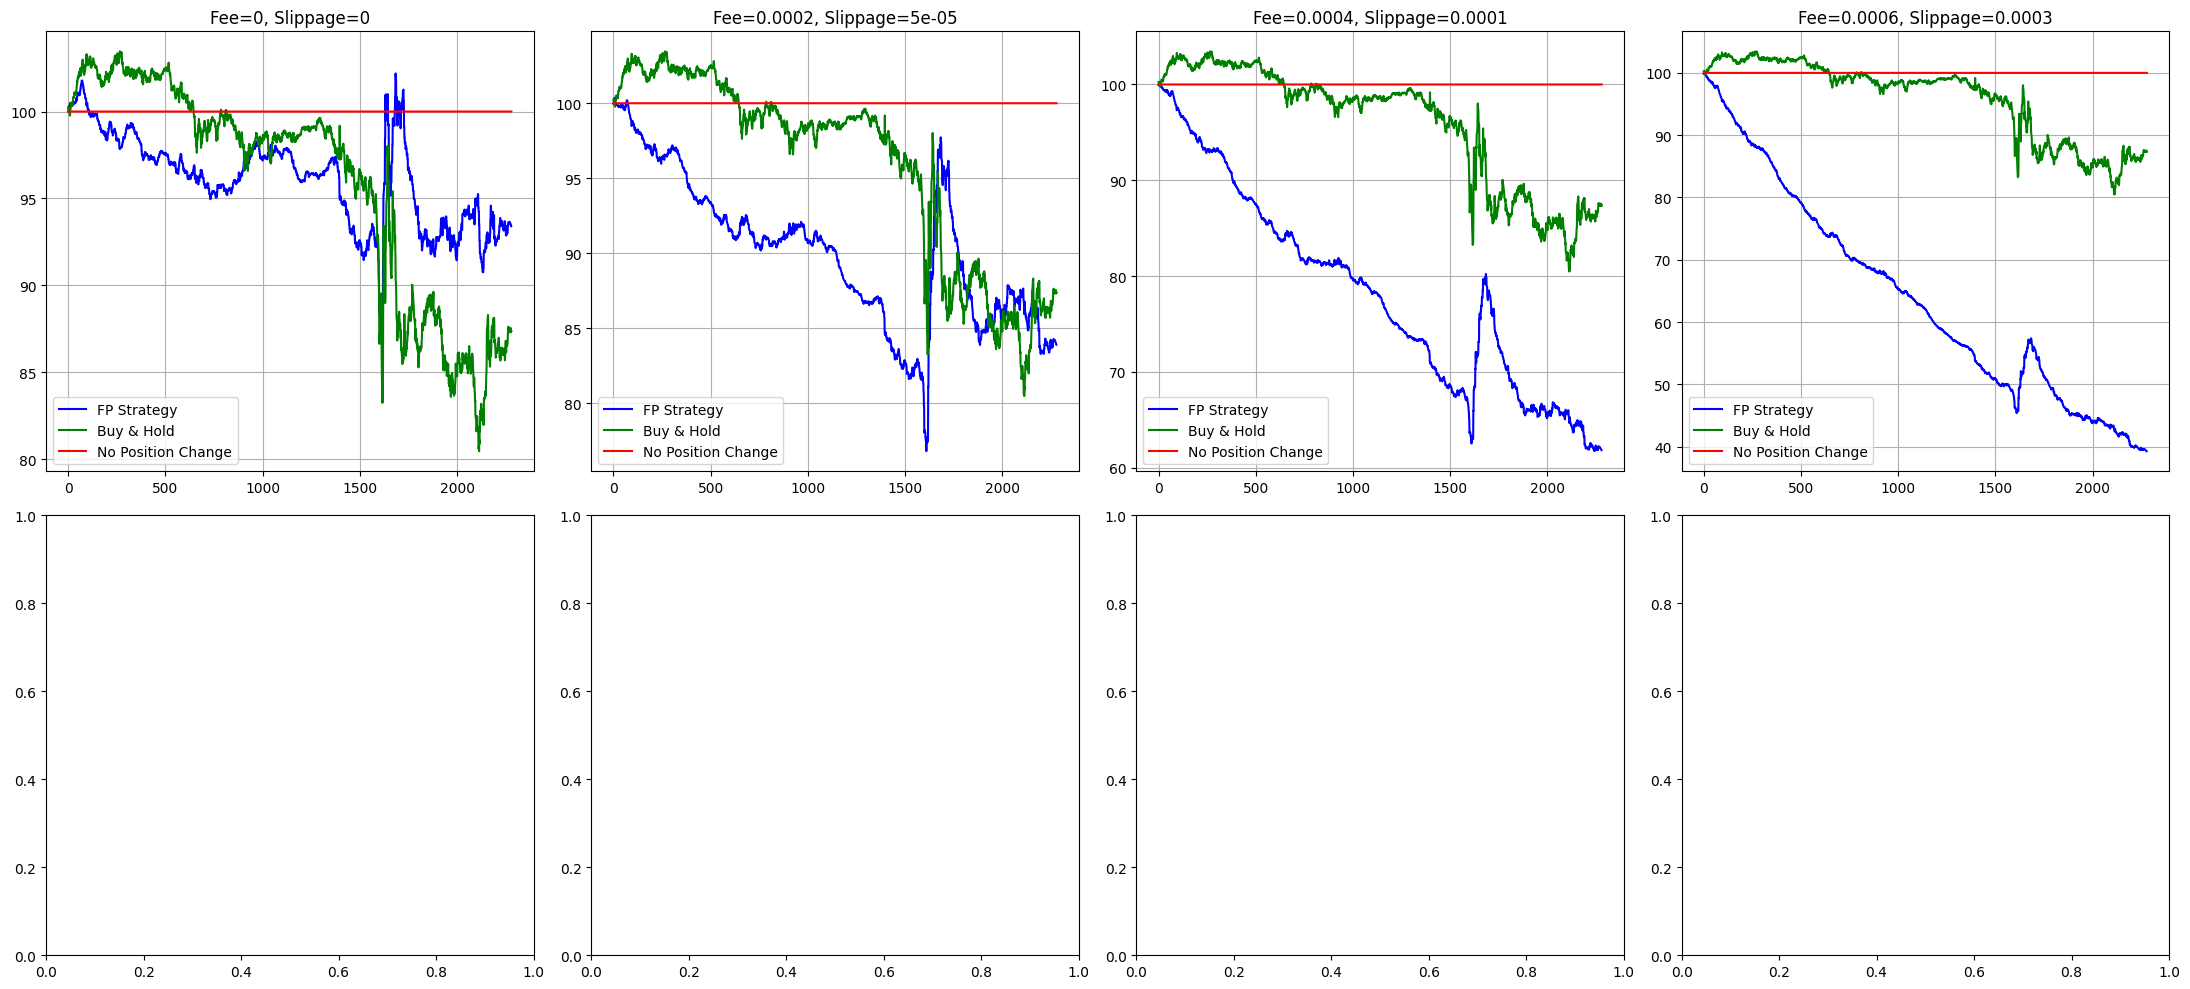


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            93.40          -6.60           87.38                 -12.62    100.0             0.0
0.0002   0.00005            83.89         -16.11           87.38                 -12.62    100.0             0.0
0.0004   0.00010            61.82         -38.18           87.38                 -12.62    100.0             0.0
0.0006   0.00030            39.26         -60.74           87.38                 -12.62    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("ADA_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


In [ ]:
import numpy as np
df = pd.read_csv("ADA_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()
df

/tmp/ipython-input-6-3011815859.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,bid_price_14,ask_price_14,obi,dobi,depth,queue_slope_bid,queue_slope_ask,net_queue_slope,depth_variance,abs_dobi
0,0,2021-04-07 11:33:59.055697+00:00,1.16205,0.0,56936.467913,258248.957367,-0.000043,-0.000129,-0.000301,-0.000473,...,1.163728,1.167601,0.030176,0.000000,172313.251449,708.509995,1292.319946,-583.809952,7301.322600,0.000000
1,1,2021-04-07 11:34:59.055697+00:00,1.16800,0.0,56491.336799,78665.286640,-0.000942,-0.001027,-0.001113,-0.001199,...,1.171682,1.174764,0.086007,0.055830,202065.982060,32906.031860,-3735.280029,36641.311890,8634.564698,0.055830
2,2,2021-04-07 11:35:59.055697+00:00,1.17530,0.0,52859.493359,48459.173836,-0.000511,-0.000596,-0.000766,-0.000851,...,1.177427,1.178533,-0.350664,-0.436671,124745.511002,1661.160095,939.500000,721.660095,5227.023721,0.436671
3,3,2021-04-07 11:36:59.055697+00:00,1.16585,0.0,50772.386336,32666.609124,-0.000729,-0.001072,-0.001158,-0.001501,...,1.168809,1.169495,-0.205278,0.145386,176105.088253,3379.469925,20739.159912,-17359.689987,10949.545694,0.145386
4,4,2021-04-07 11:37:59.055697+00:00,1.17255,0.0,113579.364184,82545.397704,-0.000384,-0.000469,-0.000810,-0.000981,...,1.175492,1.175407,-0.125134,0.080144,185075.560577,1152.589966,-8747.200073,9899.790039,7816.229732,0.080144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17104,17104,2021-04-19 09:45:00.442103+00:00,1.27325,0.0,13671.251598,25358.764361,-0.000039,-0.000275,-0.000589,-0.000668,...,1.275096,1.275724,0.096262,0.073385,168475.729645,16921.269684,-9670.419678,26591.689362,5828.821592,0.073385
17105,17105,2021-04-19 09:46:00.442103+00:00,1.27200,0.0,9916.946518,33674.957421,-0.000314,-0.000393,-0.000472,-0.000550,...,1.273808,1.274201,-0.019056,-0.115318,169182.128290,982.119873,-2962.099981,3944.219854,5990.383981,0.115318
17106,17106,2021-04-19 09:47:00.442103+00:00,1.27255,0.0,32589.054204,43483.963978,-0.000275,-0.000432,-0.000589,-0.000668,...,1.274240,1.274082,-0.130746,-0.111691,169617.018921,797.260010,-11611.109558,12408.369568,6419.770596,0.111691
17107,17107,2021-04-19 09:48:00.442103+00:00,1.27305,0.0,3437.251449,7907.458513,-0.000039,-0.000746,-0.000825,-0.000903,...,1.274975,1.274896,-0.277337,-0.146591,192464.179321,-4577.289886,13543.689453,-18120.979340,6720.218170,0.146591


/tmp/ipython-input-4-4261587749.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


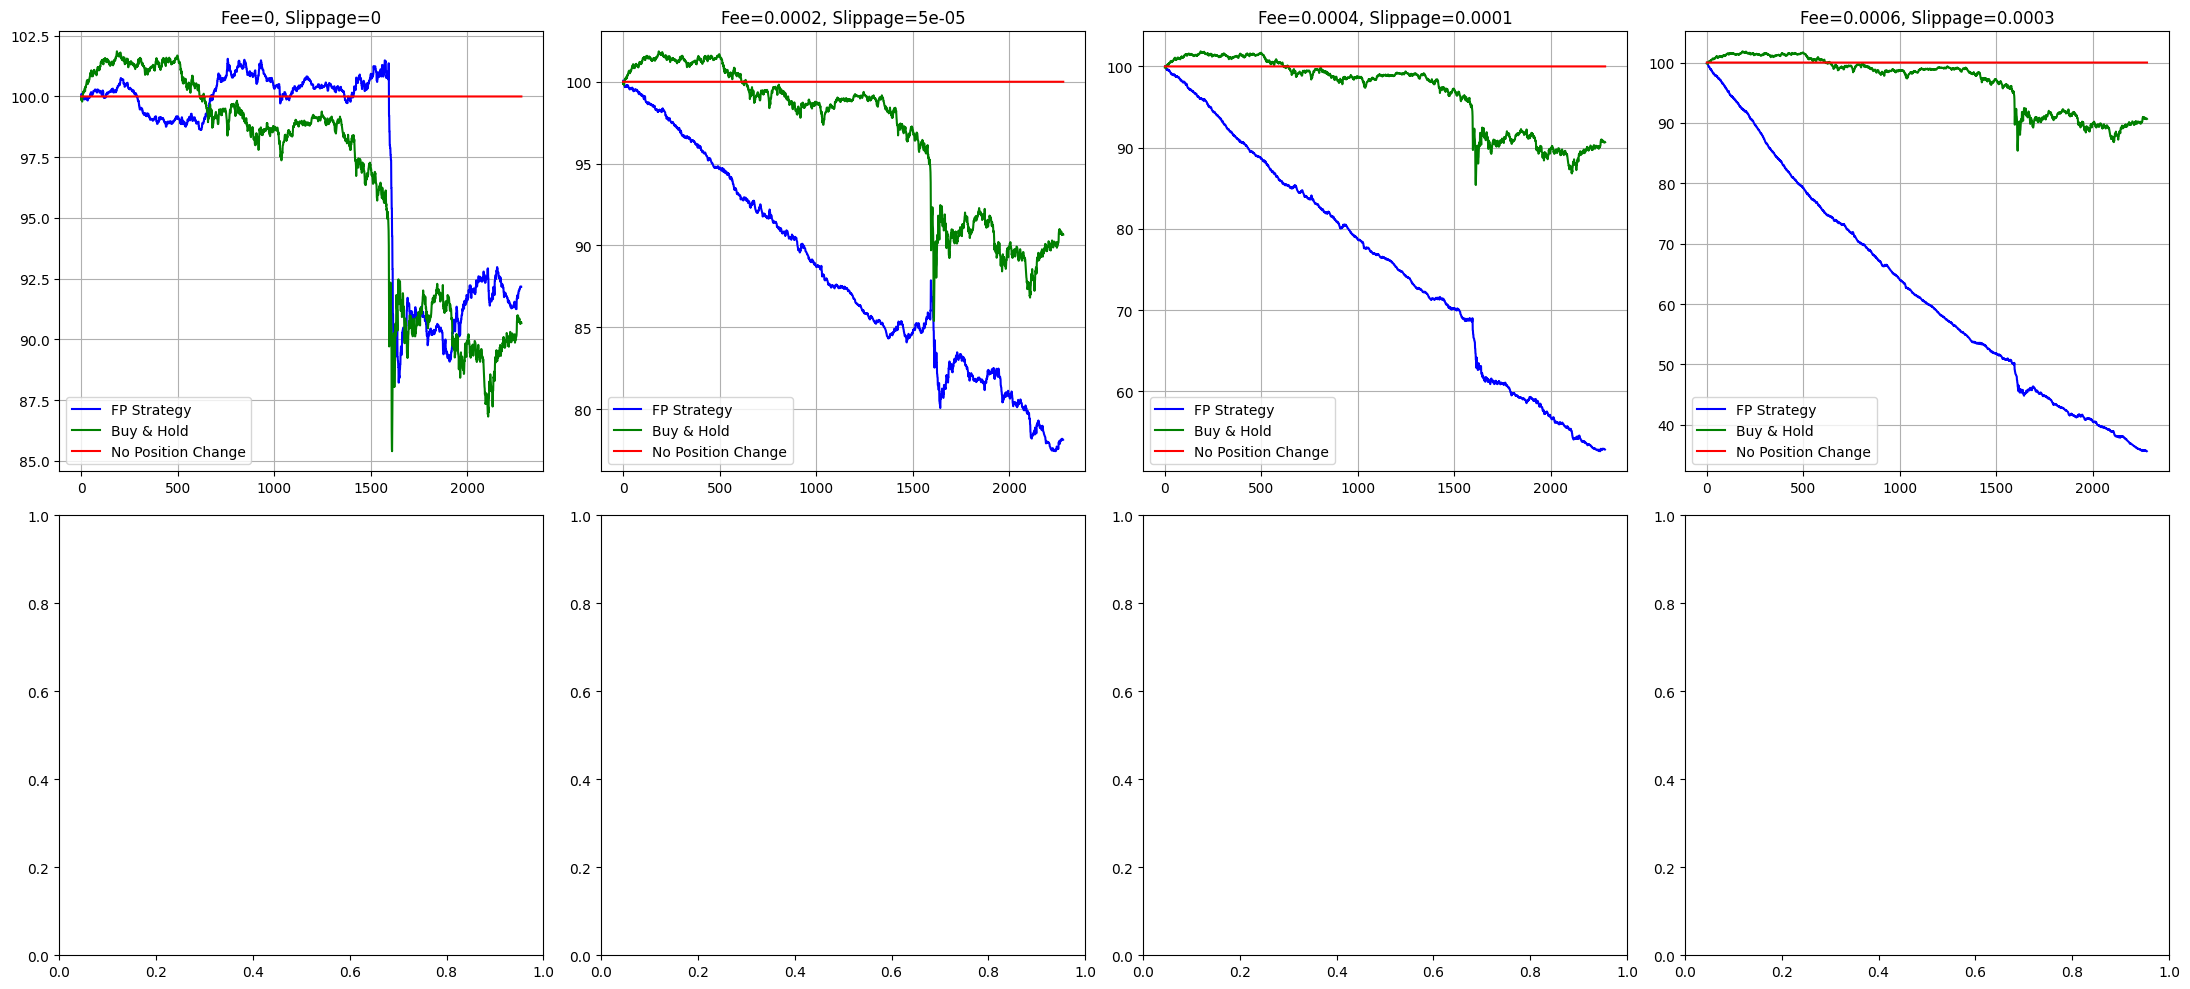


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            92.16          -7.84           90.67                  -9.33    100.0             0.0
0.0002   0.00005            78.13         -21.87           90.67                  -9.33    100.0             0.0
0.0004   0.00010            52.83         -47.17           90.67                  -9.33    100.0             0.0
0.0006   0.00030            35.62         -64.38           90.67                  -9.33    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("BTC_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-6-3446055485.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-6-3446055485.py:66: RuntimeWarning: overflow encountered in scalar multiply
  mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
/tmp/ipython-input-6-3446055485.py:68: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-6-3446055485.py:40: RuntimeWarning: overflow encountered in divide
  positions = np.tanh(signal / threshold)
/tmp/ipython-input-6-3446055485.py:67: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)


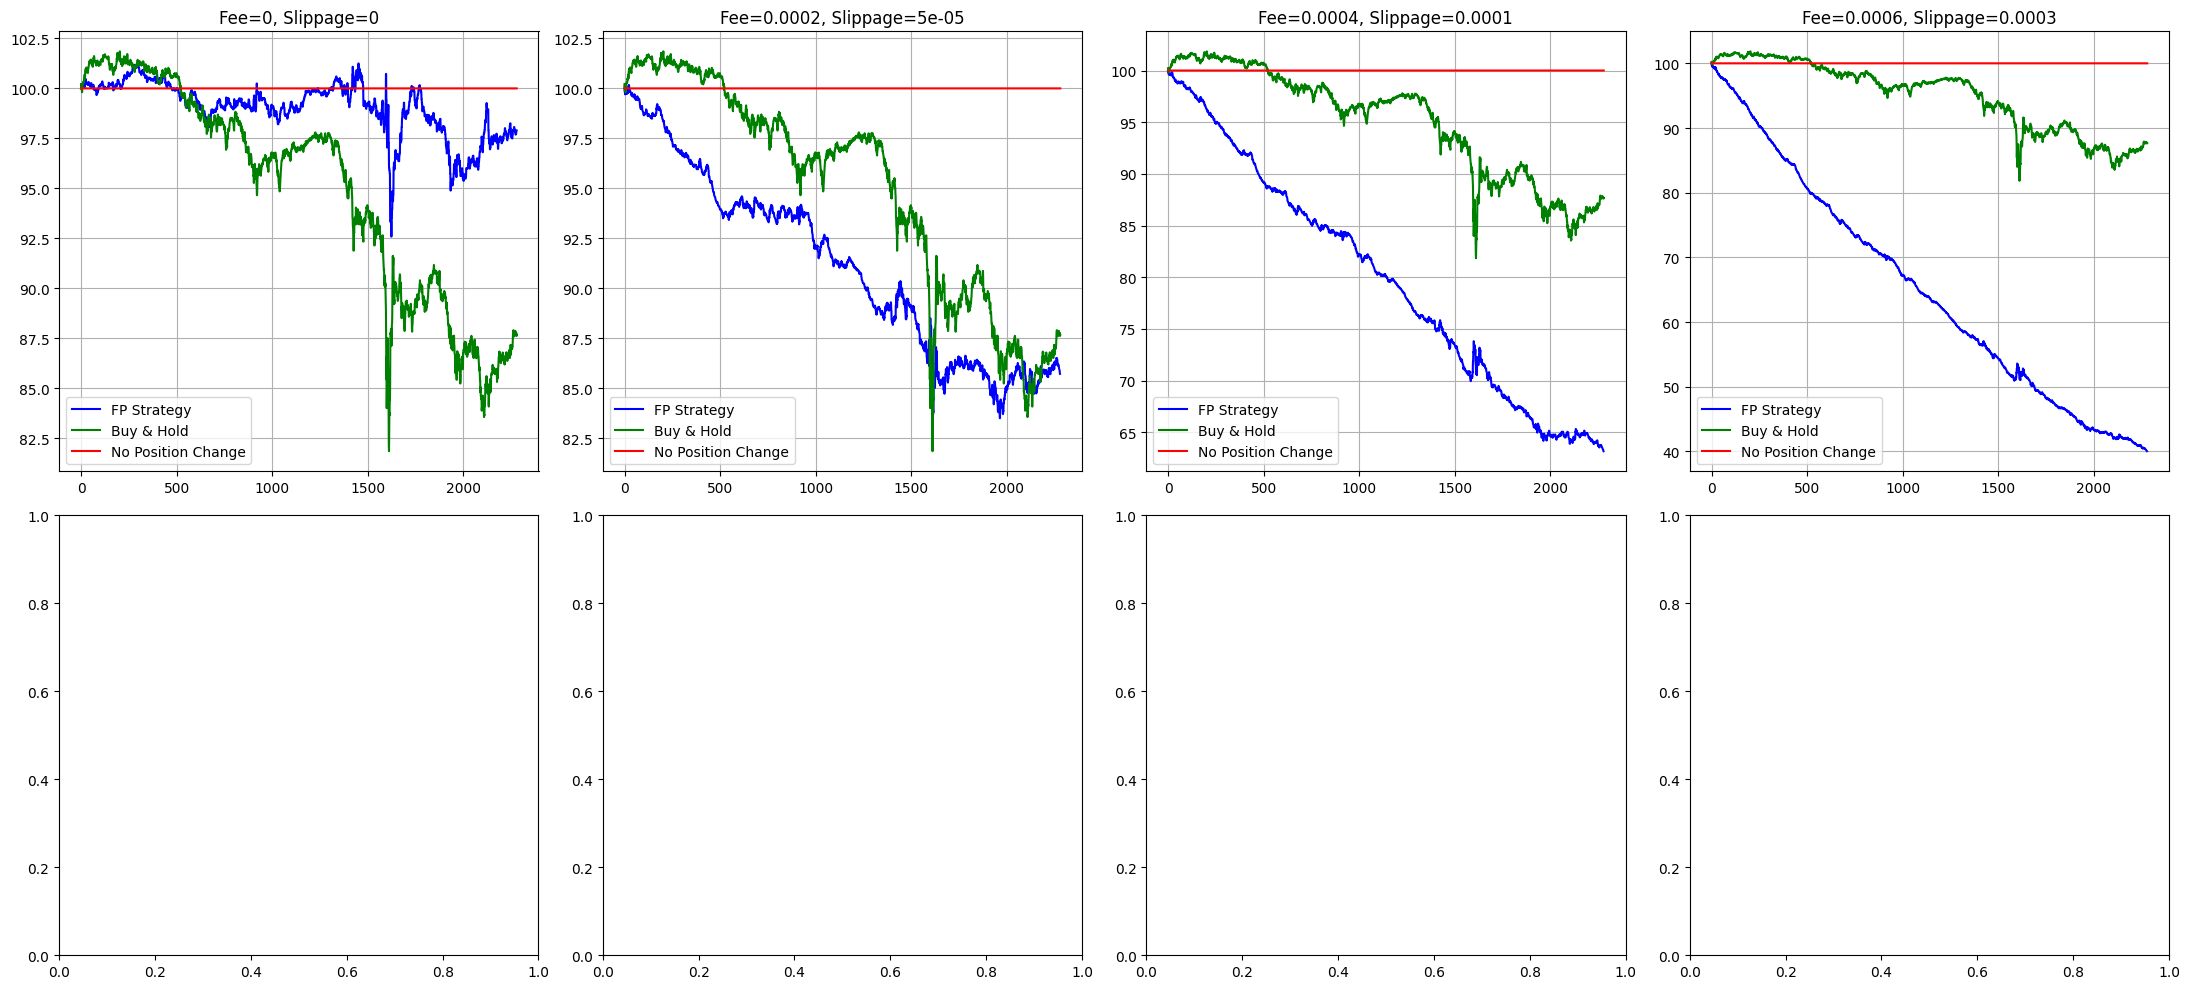


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            97.90          -2.10           87.65                 -12.35    100.0             0.0
0.0002   0.00005            85.71         -14.29           87.65                 -12.35    100.0             0.0
0.0004   0.00010            63.18         -36.82           87.65                 -12.35    100.0             0.0
0.0006   0.00030            40.04         -59.96           87.65                 -12.35    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

# Load and preprocess data
df = pd.read_csv("ETH_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.tanh(signal / threshold)
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    costs[~trade_mask] = 0
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = np.abs(first_position) * (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))
